# Camera calibration Sim

Objective: know the camera calibration info to reconstruct the camera matrix. 

The mapping between a world point $P$ and your projection $p$ in the image plane is described by: 

$$ \tilde{p} = M_{int} \cdot M_{ext} \cdot \tilde{P} $$

Where: 

$$ M_{int} = \begin{bmatrix}
f_x&0 &O_x \\
0& f_y&O_y \\
0& 0&1
\end{bmatrix} $$

and 

$$ M_{ext} = \begin{bmatrix}
r_{11}&r_{12}  &r_{13} & t_x \\ r_{21} &r_{22} &r_{23}&t_y \\ r_{31}&r_{32} &r_{33}  & t_z\\ 0&0&0&1
\end{bmatrix} $$

$M_{int}$ represents the internal parameters of the camera. 
- $(f_x,f_y)$ are the focal distance in pixels, in the $x$ and $y$ directions
- $(O_x,O_y)$ is the principal point 

$M_{ext}$ represents the position and orientation of the camera in the world coordinate frame 

---

### This parameters must be recovers this parameters from the simulation. 

The internal parameters must be recover from the vision sensor properties. 

<p align = "center">
    <img src = '../vision-sensor.jpeg'>
</p>

**Fist problem:** Cannot set the focal length.
- Use the perspective angle to set the focal length.
- $ \alpha = 2\cdot\text{atan}(\frac{d}{2f})$, where $\alpha$ is the perspective angle, $d$ is the sensor size and $f$ is the focal length.
- This parameters can be recovered from the Raspberry Pi Camera V2 Documentation. 

**Second problem:** Cannot know the pixel density.
- The $K$ is definied using the focal lenght in pixels units, not in milimeters. 
- To convert, it's necessary to know the pixel density of the vision sensor. 
- Set to the pixel density of the V2 Cam? 

--- 

The camera extrinsic parameters are recovered from the simulation using `sim.getObjectMatrix()`. This function returns the position and orientation of an object in relation to another

<p align = "center">
    <img src = '../object-matrix.jpeg'>
</p>

Your arguments are: 
- objectHandle
- relativeToObjectHandle: indicates relative to which reference frame the matrix is specified.
    - Specify sim.handle_world to set the absolute transformation matrix, sim.handle_inverse to set the inverse of the absolute transformation matrix, sim.handle_parent to set the transformation matrix relative to the object's parent, or an object handle relative to whose reference frame the transformation matrix is specified. 


In [2]:
# Import librarys
import time
import math
import numpy as np
import cv2
import random
import glob
import matplotlib.pyplot as plt
from scipy.linalg import svd
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

## CoppeliaSim Scene config


In [3]:

# Connect and configure the simulation 
client = RemoteAPIClient()
sim = client.getObject('sim')

# When simulation is not running, ZMQ message handling could be a bit
# slow, since the idle loop runs at 8 Hz by default. So let's make
# sure that the idle loop runs at full speed for this program:
defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)   
sim.setInt32Param(sim.intparam_idle_fps, 0)

# Get the vision sensor handle
visionSensorHandle = sim.getObject('/Vision_sensor')
cubo = sim.getObject('/Cuboid[3]')

## Recover camera parameters from scene

In [29]:
isZhang = False

# Vision sensor internal parameters
# Run this before to adjust the perspective angle
def get_perspective_angle(focal_length, sensor_size):
    perspective_angle = 2*math.atan(sensor_size / (2*focal_length))
    perspective_angle = perspective_angle*(180/math.pi)
    print(perspective_angle)
    return perspective_angle

get_perspective_angle(3.04,3.68)

focal_length = 3.04
# Defined in vision sensor parameters
image_size = (1280,720)

# Pixel density defined by the sensor resolution
pixel_density = (830,829)

# Cria a matriz K
k_matrix = np.array([[focal_length*pixel_density[0], 0, image_size[0]/2],
                    [0, focal_length*pixel_density[1], image_size[1]/2],
                    [0, 0, 1]], dtype=np.float64)

# Start simulation in CoppeliaSim
sim.startSimulation()

# Get Vision_sensor transformation matrix
transformation_matrix = sim.getObjectMatrix(visionSensorHandle, -1)

transformation_matrix = np.array(transformation_matrix).reshape(3,4)

sim.stopSimulation()

# Cria a matriz de câmera C
camera_matrix = k_matrix @ transformation_matrix
print("The camera matrix is: \n",camera_matrix)

62.369949317476774
The camera matrix is: 
 [[-2.52320000e+03  6.40000000e+02 -4.55633481e-10 -7.27539370e+02]
 [-8.19052596e-10  3.60000000e+02  2.52016000e+03 -3.19302355e+03]
 [-8.27292428e-13  1.00000000e+00  1.03472786e-13  6.58429641e-01]]


## Get the calibration images

In [34]:
# Start simulation in CoppeliaSim
sim.startSimulation()

# index of the calibration image
n = 2

# See the Vision sensor image
while (t := sim.getSimulationTime()) < 300:
    img, resX, resY = sim.getVisionSensorCharImage(visionSensorHandle)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
    # In CoppeliaSim images are left to right (x-axis), and bottom to top (y-axis)
    # (consistent with the axes of vision sensors, pointing Z outwards, Y up)
    # and color format is RGB triplets, whereas OpenCV uses BGR:
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
    cv2.imshow('', img)
    cv2.waitKey(1)

    p=sim.getObjectPosition(cubo,-1)

    print(p, transformation_matrix,'\n','\n')
    time.sleep(0.75)

    cv2.imwrite(f'image{n}.jpg',img)

sim.stopSimulation()

cv2.destroyAllWindows()

sim.stopSimulation()

[0.6870531367164906, -1.5622699999999992, 1.0] [[-1.00000000e+00 -8.27292428e-13 -2.06823107e-13 -4.55348106e-01]
 [-2.06823107e-13 -1.03472786e-13  1.00000000e+00 -1.36104780e+00]
 [-8.27292428e-13  1.00000000e+00  1.03472786e-13  6.58429641e-01]] 
 

[0.7651633229589269, -1.6285477532422932, 1.247153396299097] [[-1.00000000e+00 -8.27292428e-13 -2.06823107e-13 -4.55348106e-01]
 [-2.06823107e-13 -1.03472786e-13  1.00000000e+00 -1.36104780e+00]
 [-8.27292428e-13  1.00000000e+00  1.03472786e-13  6.58429641e-01]] 
 

[0.6430172701330752, -1.6257052063949695, 1.20346369290564] [[-1.00000000e+00 -8.27292428e-13 -2.06823107e-13 -4.55348106e-01]
 [-2.06823107e-13 -1.03472786e-13  1.00000000e+00 -1.36104780e+00]
 [-8.27292428e-13  1.00000000e+00  1.03472786e-13  6.58429641e-01]] 
 

[0.7042902147448225, -1.573167692582359, 1.155329168344041] [[-1.00000000e+00 -8.27292428e-13 -2.06823107e-13 -4.55348106e-01]
 [-2.06823107e-13 -1.03472786e-13  1.00000000e+00 -1.36104780e+00]
 [-8.27292428e-13  1

1

## Extract world points

In [31]:
if isZhang: 
    patternSize = (7,7)
    squareSize = (10)
    imgSize = (1280,720)

    def construct3DPoints(patternSize,squareSize):
        X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
        X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
        X = X * squareSize
        return X

    boardPoints = construct3DPoints(patternSize,squareSize)
    print(boardPoints)
    worldPoints = []

else: 
    #Pontos no cubo que estão visiveis 
    worldPoints = np.array([[0.,2.,0.],
                            [1.,0.,0.],
                            [2.,0.,0.],
                            [3.,0.,0.],
                            [0.,3.,1.],
                            [0.,2.,1.],
                            [0.,1.,1.],
                            [1.,0.,1.],
                            [2.,0.,1.],
                            [3.,0.,1.],
                            [0.,3.,2.],
                            [0.,2.,2.],
                            [0.,1.,2.],
                            [1.,0.,2.],
                            [2.,0.,2.],
                            [3.,0.,2.],
                            [0.,3.,3.],
                            [0.,2.,3.],
                            [0.,1.,3.],
                            [1.,0.,3.],
                            [2.,0.,3.],
                            [3.,0.,3.],
                            [1.,1.,3.],
                            [2.,3.,3.],
                            [2.,2.,3.],
                            [2.,1.,3.],
                            [3.,2.,3.]]) 

[[0. 2. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [0. 3. 1.]
 [0. 2. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [2. 0. 1.]
 [3. 0. 1.]
 [0. 3. 2.]
 [0. 2. 2.]
 [0. 1. 2.]
 [1. 0. 2.]
 [2. 0. 2.]
 [3. 0. 2.]
 [0. 3. 3.]
 [0. 2. 3.]
 [0. 1. 3.]
 [1. 0. 3.]
 [2. 0. 3.]
 [3. 0. 3.]
 [1. 1. 3.]
 [2. 3. 3.]
 [2. 2. 3.]
 [2. 1. 3.]
 [3. 2. 3.]]


## Extract image points

number of corners detected:  27
[[[564.3152  252.68439]]

 [[694.6928  243.68637]]

 [[826.42706 233.55133]]

 [[625.03827 261.8383 ]]

 [[573.5912  340.64044]]

 [[883.82324 385.4333 ]]

 [[530.44305 407.4186 ]]

 [[640.3677  443.95663]]

 [[589.8389  503.97058]]

 [[759.52905 226.50145]]

 [[834.59064 490.49197]]

 [[640.3723  214.56644]]

 [[772.36536 436.53787]]

 [[882.011   217.62466]]

 [[632.4177  355.56662]]

 [[762.4857  252.42708]]

 [[582.48773 424.63785]]

 [[695.0399  220.20595]]

 [[829.6393  323.54968]]

 [[746.915   206.28847]]

 [[768.48425 346.7792 ]]

 [[777.3517  521.30194]]

 [[831.4153  409.56305]]

 [[510.4737  245.18546]]

 [[521.0537  327.31122]]

 [[883.33    303.22266]]

 [[886.38837 462.90256]]]


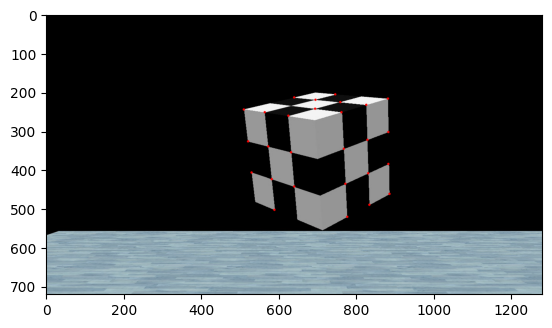

In [24]:
if isZhang:
    counter = 0
    imagePoints = []
    images = glob.glob('../calibration-images/*.jpg')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
        if ret == True:
            print("Corners found in image" + str(fname)) #- see if corners are found 
            imagePoints.append(corners)
            worldPoints.append(boardPoints)
            counter+=1

    print("using " + str(counter) + " images")

else: 
    img = cv2.imread('image1.jpg') 
  
    # convert image to gray scale image 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    # detect corners with the goodFeaturesToTrack function. 
    corners = cv2.goodFeaturesToTrack(gray, 27, 0.01, 10) 
    
    print("number of corners detected: ",corners.shape[0])
    
    # Set the needed parameters to find the refined corners
    winSize = (5, 5)
    zeroZone = (-1, -1)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)
    # Calculate the refined corner locations
    corners = cv2.cornerSubPix(gray, corners, winSize, zeroZone, criteria)

    print(corners)

    # we iterate through each corner,  
    # making a circle at each point that we think is a corner. 
    corners = np.intp(corners) 
    for i in corners: 
        x, y = i.ravel()
        cv2.circle(img, (x, y), 3, 255, -1) 
    
    plt.imshow(img), plt.show() 

In [ ]:
image_corners = np.array([[589.8389, 503.97058],
                          [777.3517,  521.30194],
                          [834.59064, 490.49197],
                          [886.38837, 462.90256],
                          [530.44305, 407.4186],
                          [582.48773, 424.63785],
                          [640.3677,  443.95663],
                          [772.36536, 436.53787],
                          [831.4153,  409.56305],
                          [883.82324, 385.4333],
                          [521.0537,  327.31122],
                          [573.5912, 340.64044],
                          [632.4177,  355.56662],
                          [768.48425, 346.7792],
                          [829.6393,  323.54968],
                          [883.33,    303.22266],
                          [510.4737,  245.18546],
                          [564.3152,  252.68439],
                          [625.03827, 261.8383 ],
                          [762.4857,  252.42708],
                          [826.42706, 233.55133],
                          [882.011,   217.62466],
                          [694.6928,  243.68637],
                          [640.3723,  214.56644],
                          [695.0399,  220.20595],
                          [759.52905, 226.50145],
                          [746.915,   206.28847]








                        


])

## Compute the camera matrix

In [ ]:
if isZhang: 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    flagsCalib = cv2.CALIB_RATIONAL_MODEL
    ret, cameraMatrix, k, rvecs, tvecs = cv2.calibrateCamera(worldPoints, imagePoints, imgSize, None, None,flags=flagsCalib)

    print("Using "+str(counter)+" of "+str(len(images))+" images")
    print("RMS re-projection error:", ret)
    print("Camera Matrix:\n", cameraMatrix)
    print("Distortion Parameters:\n", k)
    
else: 

    def calibrate_camera(world_points, image_points):
        """
        Função para encontrar a matriz de câmera C usando o algoritmo DLT.
        
        Args: 
            world_points: Array de pontos 3D na cena.
            image_points: Array de pontos 2D projetados na imagem.

        Return: 
            C_matrix: numpy array contendo a matriz de câmera estimada. 
        """

        if len(world_points) != len(image_points): 
            raise ValueError("Must be the same number of World points and Image points")
        
        if len(world_points) < 6 | len(image_points) < 6 :
            raise ValueError("Must have a minimum of 6 points to compute the camera matrix")


        Q = []
        for i in range(len(world_points)):
            X, Y, Z = world_points[i]
            u,v  = image_points[i]
            Q.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
            Q.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])

        Q = np.array(Q)
        #print(Q)

        # Resolva o sistema de equações usando SVD
        _, _, V = svd(Q)
        c = V[-1, :12]
        #print(c)

        # Reconstrua a matriz de projeção da câmera
        C_matrix = c.reshape(3, 4)
        print(C_matrix)

        return C_matrix
    
    camera_matrix = calibrate_camera(worldPoints,imagePoints)

## Results 

In [ ]:
# Plots and stuff like that